# Weight-updating EXE simulations

In this notebook, we will use `sampling_simulator` to simulate the sampling in the alchemical space by the Wang-Landau algorithm in weight-updating expanded ensemble (EXE) simulations. Specifically, we will compare the sampling behaviors between a single EXE simulation and decoupled replicas of EXE simulations. The system of interest we focus here has 40 alchemical intermediate states. 

In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from sampling_simulator.utils import calc_rmse
from sampling_simulator.wang_landau_algorithm import WL_Simulator

rc('font', **{
        'family': 'sans-serif',
        'sans-serif': ['DejaVu Sans'],
        'size': 10,
    })
# Set the font used for MathJax - more on thiprint(images)
rc('mathtext', **{'default': 'regular'})
plt.rc('font', family='serif')

In [2]:
params_dict = {
    'n_steps': 200000,
    'wl_ratio': 0.8,
    'wl_scale': 0.7,
    'wl_delta': 10,             # init_wl_delta in GROMACS
    'wl_delta_cutoff': 0.001,   # weight-equil-wl-delta in GROMACS
    'verbose': False
}

In [3]:
f_ref = np.array([
    0.0, 57.805215366068346, 112.49325354921746, 163.9053804543671, 211.1228680338599, 254.58059732433938, 295.5660812208014,
    334.6531501257331, 371.45476696195874, 406.65593569265764, 439.2891881651442, 469.42891547180665, 497.15580279170484,
    522.4463901739871, 545.4157353241036, 566.0988033555478, 584.5719734781715, 600.4976380135653, 614.3116862505102, 625.6622986339568,
    634.9000108527418, 639.2141393579959, 643.3695667349867, 647.2981063000773, 650.9040500232999, 652.5280053311945, 653.9774650452159, 
    655.178901008137, 656.0135314031018, 656.2533557264542, 656.2030286485515, 655.7434099493724, 654.7837017140891, 653.4171450203427,
    651.8897886531751, 650.4268292093915, 649.155734577982, 647.8279229679827, 646.8756268046341, 645.4731180684097,
], dtype=float)

## 1. Whole-range EXE simulation

In [4]:
t_equil_list, rmse_list = [], []
for i in range(3):
    simulator = WL_Simulator(params_dict, f_ref)
    simulator.run()
    t_equil_list.append(simulator.equil_time)
    rmse_list.append(calc_rmse(simulator.g, f_ref - f_ref[0]))
    

t_equil = np.mean(t_equil_list)
t_equil_err = np.std(t_equil_list, ddof=1)
rmse = np.mean(rmse_list)
rmse_err = np.std(rmse_list, ddof=1)
comp_cost_rep = []

print('Whole-range EXE simulation')
print(f'  Equilibration time: {t_equil:.0f} +/- {t_equil_err:.0f} steps')
print(f'  RMSE: {rmse:.3f} +/- {rmse_err:.3f} kT')

Whole-range EXE simulation
  Equilibration time: 47664 +/- 1668 steps
  RMSE: 0.024 +/- 0.012 kT


Just to demonstrate, one can examine the final alchemical weights, or the biased free energy surface as follows:

In [5]:
print(f'Final alchemical weights: {simulator.g}')
print(f'Biased free energies: {simulator.f_current}')

Final alchemical weights: [  0.          57.83545239 112.5199219  163.96654266 211.17346103
 254.63195428 295.60458967 334.69752039 371.48130113 406.67571316
 439.31536454 469.46319845 497.16429746 522.48008559 545.46706079
 566.14157314 584.60591622 600.52418836 614.34824601 625.70690825
 634.91805322 639.22968151 643.38546703 647.33071571 650.94019724
 652.57620012 654.00582476 655.21703846 656.03454892 656.29125968
 656.23437823 655.78463706 654.79297773 653.43963532 651.92320986
 650.44326182 649.18223746 647.89923462 646.90025603 645.52998554]
Biased free energies: [ 0.         -0.03023703 -0.02666835 -0.0611622  -0.050593   -0.05135696
 -0.03850845 -0.04437027 -0.02653416 -0.01977747 -0.02617638 -0.03428297
 -0.00849467 -0.03369542 -0.05132547 -0.04276978 -0.03394274 -0.02655035
 -0.03655976 -0.04460961 -0.01804237 -0.01554216 -0.01590029 -0.03260941
 -0.03614721 -0.04819479 -0.02835971 -0.03813745 -0.02101752 -0.03790396
 -0.03134958 -0.04122711 -0.00927602 -0.0224903  -0.033421

Or, one can plot the following figures using other functions defined in the class `WL_simulator`:

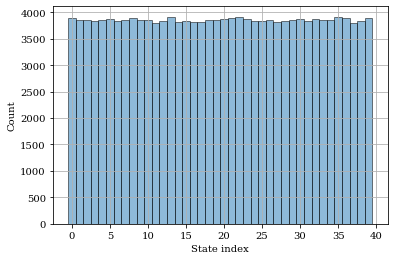

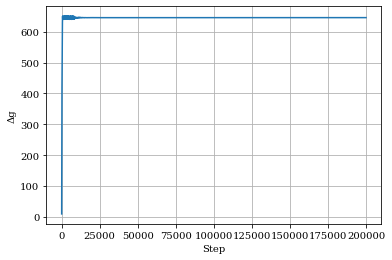

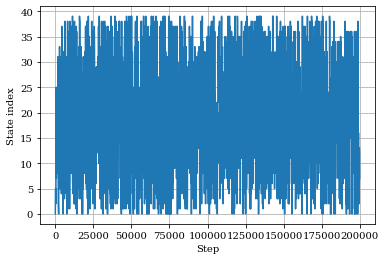

In [6]:
simulator.plot_hist()
simulator.plot_timeseries(simulator.dg, 'Δg', 'dg.png')
simulator.plot_timeseries(simulator.traj, 'State index', 'traj.png')

In [7]:
png_files = glob.glob('*.png')
for png_file in png_files:
    os.remove(png_file)  # remove all png files we just created

Below we will compare the compuational cost of this simulation with those of ensembles of decoupled EXE replicas, with the number of replicas ranging from 1 to 6. Note that in each ensemble, different replicas of EXE simulations sample a different but overlapping range of states. Here we create an arry to keep track of the least possible computational cost for different numbers of replicas. Here, the whole-range EXE simulation is a special case where the number of replicas is 1. 

In [8]:
cost, cost_err = np.zeros(6), np.zeros(6)
cost[0] = t_equil
cost_err[0] = t_equil_err

## 2. Decoupled EXE replicas
### 2-1. Decoupled EXE replicas with different overlaps

Here we first explore different ensembles of decoupled EXE replicas that have different numbers of overlapping states between neighboring alchemical ranges. With `n_sim` (the number of replicas) set to 4, we performed simulations for different values of `s`, the state shifts between neighboring replicas, and compare their computational cost. Each case will be performed in 10 replicates. Below we create a function specifically for doing such a task. 

In [9]:
def decoupled_EXE(n_sim, s, n_sub, f_ref, n_replicates=3):
    t_equil_all = []  # the averaged equilibration time for each alchemical range
    t_equil_err_all = []  # the standard deviation of the equilibration time for each alchemical range
    for i in range(n_sim):
        # Below are the equilibration time and RMSE of all replicates for a ceterain alchemical range.
        t_equil_list, rmse_list = [], []
        for j in range(n_replicates):
            f_ref_sub = f_ref[i * s : i * s + n_sub]
            simulator = WL_Simulator(params_dict, f_ref_sub)
            simulator.run()
            t_equil_list.append(simulator.equil_time)
            rmse_list.append(calc_rmse(simulator.g, f_ref_sub - f_ref_sub[0]))

        t_equil = np.mean(t_equil_list)
        t_equil_err = np.std(t_equil_list, ddof=1)

        rmse = np.mean(rmse_list)
        rmse_err = np.std(rmse_list, ddof=1)

        t_equil_all.append(t_equil)
        t_equil_err_all.append(t_equil_err)

        print(f'State range: {i * s}-{i * s + n_sub - 1}')
        print(f'  Equilibration time: {t_equil:.0f} +/- {t_equil_err:.0f} steps')
        print(f'  RMSE: {rmse:.3f} +/- {rmse_err:.3f} kT\n')

    return t_equil_all, t_equil_err_all

In [10]:
n_sim = 4
comp_cost, comp_cost_err = [], []
s = range(1, 10)  # from high to low overlap
n_sub = [37, 34, 31, 28, 25, 22, 19, 17, 13]  # the corresponding number of states in each alchemical range
for i in range(9):
    section_title = f'Test {i + 1}: n_sim = {n_sim}, s = {s[i]}, n_sub = {n_sub[i]}'
    print(section_title)
    print('=' * len(section_title))
    t_equil, t_equil_err = decoupled_EXE(n_sim, s[i], n_sub[i], f_ref)
    comp_cost.append(np.max(t_equil) * n_sim)
    comp_cost_err.append(t_equil_err[np.argmax(t_equil)] * n_sim)
    print(f'Computational cost: {comp_cost[-1]:.0f} +/- {comp_cost_err[-1]:.0f} A.U. \n')

Test 1: n_sim = 4, s = 1, n_sub = 37
State range: 0-36
  Equilibration time: 43426 +/- 1859 steps
  RMSE: 0.019 +/- 0.005 kT

State range: 1-37
  Equilibration time: 39657 +/- 1074 steps
  RMSE: 0.016 +/- 0.001 kT

State range: 2-38
  Equilibration time: 43428 +/- 2105 steps
  RMSE: 0.017 +/- 0.003 kT

State range: 3-39
  Equilibration time: 40017 +/- 1952 steps
  RMSE: 0.021 +/- 0.010 kT

Computational cost: 173712 +/- 8418 A.U. 

Test 2: n_sim = 4, s = 2, n_sub = 34
State range: 0-33
  Equilibration time: 38829 +/- 2893 steps
  RMSE: 0.022 +/- 0.009 kT

State range: 2-35
  Equilibration time: 35760 +/- 1619 steps
  RMSE: 0.021 +/- 0.003 kT

State range: 4-37
  Equilibration time: 35014 +/- 1416 steps
  RMSE: 0.018 +/- 0.004 kT

State range: 6-39
  Equilibration time: 33640 +/- 4530 steps
  RMSE: 0.026 +/- 0.011 kT

Computational cost: 155316 +/- 11572 A.U. 

Test 3: n_sim = 4, s = 3, n_sub = 31
State range: 0-30
  Equilibration time: 35479 +/- 1796 steps
  RMSE: 0.018 +/- 0.001 kT

S

### 

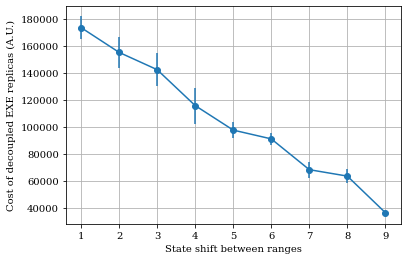

In [11]:
plt.figure()
plt.errorbar(s, comp_cost, yerr=comp_cost_err, marker='o')
plt.xlabel('State shift between ranges')
plt.ylabel('Cost of decoupled EXE replicas (A.U.)')
plt.grid()

From the figure above, it's clear that with the same number of replicas, the less the overlap is, the lower the computational cost is. Here, we explore decoupled EXE replicas with other numbers of replicas and minimal overlap. Below we first update `comp_cost` with the loweest possible cost at `n_sim = 4`.

In [12]:
# s = 9 has the lowest cost
cost[3] = comp_cost[-1]
cost_err[3] = comp_cost_err[-1]

In [13]:
n_sim_list = [2, 3, 5, 6]
s_list = [19, 13, 7, 6]  # s values corresponding to the lower overlap, hence the lowest cost
n_sub_list = [21, 14, 12, 10]  # the corresponding number of states in each alchemical range given the values of n_sim and s
for i in range(4):
    section_title = f'Test: n_sim = {n_sim_list[i]}, s = {s[i]}, n_sub = {n_sub[i]}'
    print(section_title)
    print('=' * len(section_title))
    t_equil, t_equil_err = decoupled_EXE(n_sim_list[i], s_list[i], n_sub_list[i], f_ref)
    cost[n_sim_list[i] - 1] = np.max(t_equil) * n_sim_list[i]
    cost_err[n_sim_list[i] - 1] = t_equil_err[np.argmax(t_equil)] * n_sim_list[i]
    print(f'Computational cost: {cost[n_sim_list[i]-1]:.0f} +/- {cost_err[n_sim_list[i] - 1]:.0f} A.U. \n')


Test: n_sim = 2, s = 1, n_sub = 37
State range: 0-20
  Equilibration time: 19334 +/- 1794 steps
  RMSE: 0.022 +/- 0.003 kT

State range: 19-39
  Equilibration time: 15037 +/- 1557 steps
  RMSE: 0.016 +/- 0.004 kT

Computational cost: 38668 +/- 3589 A.U. 

Test: n_sim = 3, s = 2, n_sub = 34
State range: 0-13
  Equilibration time: 10526 +/- 538 steps
  RMSE: 0.022 +/- 0.005 kT

State range: 13-26
  Equilibration time: 9657 +/- 622 steps
  RMSE: 0.024 +/- 0.008 kT

State range: 26-39
  Equilibration time: 9821 +/- 643 steps
  RMSE: 0.020 +/- 0.003 kT

Computational cost: 31577 +/- 1615 A.U. 

Test: n_sim = 5, s = 3, n_sub = 31
State range: 0-11
  Equilibration time: 7881 +/- 462 steps
  RMSE: 0.023 +/- 0.017 kT

State range: 7-18
  Equilibration time: 7967 +/- 943 steps
  RMSE: 0.023 +/- 0.010 kT

State range: 14-25
  Equilibration time: 7309 +/- 881 steps
  RMSE: 0.024 +/- 0.005 kT

State range: 21-32
  Equilibration time: 7002 +/- 877 steps
  RMSE: 0.017 +/- 0.004 kT

State range: 28-39

Text(0, 0.5, 'Computational cost (A.U.)')

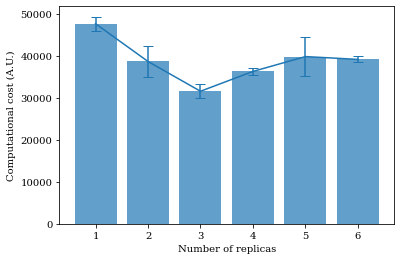

In [14]:
plt.figure()
plt.bar(range(1, 7), cost, alpha=0.7)
plt.errorbar(range(1, 7), cost, yerr=cost_err, capsize=5)
plt.xlabel('Number of replicas')
plt.ylabel('Computational cost (A.U.)')